In [100]:
from qiskit import *
from qiskit.circuit import Parameter,ParameterVector, Gate
from qiskit.quantum_info import Operator
from qiskit.circuit.library import *
from qiskit.visualization import array_to_latex, plot_histogram
from qutip import hilbert_dist, Qobj, fock_dm

import random

import pyswarms as ps
import pyswarms.backend as P
from pyswarms.backend.topology import Star

from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt

In [9]:
def my_hilbert_schmidt_distance(gate1, gate2):
    return np.sqrt(1 - (np.abs(np.trace(np.conj(gate1).T @ gate2))**2) / (2**3)**2)

In [82]:
class SingleQubitU(Gate):
    def __init__(self, theta, phi, lam):
        super().__init__('U1', 1, [theta, phi, lam])
    
    def _define(self):
        qc = QuantumCircuit(1)
        qc.unitary(self.to_matrix(), [0])
        self.definition = qc
    
    def to_matrix(self):
        theta = float(self.params[0])
        phi = float(self.params[1])
        lam = float(self.params[2])
        return UGate(theta, phi, lam).to_matrix()

In [6]:
class AGate(Gate):
    def __init__(self, a):
        super().__init__('A', 1, [a])
    
    def _define(self):
        qc = QuantumCircuit(1)
        qc.unitary(self.to_matrix(), [0])
        self.definition = qc
    
    def to_matrix(self):
        a = float(self.params[0])
        return np.array([[1, 0], [0, np.exp(1j*a)]])

In [12]:
ccz_qc = QuantumCircuit(3)
ccz_qc.ccz(0, 1, 2)
ccz_gate = Operator(ccz_qc).data
array_to_latex(ccz_gate, prefix="\\text{CCZ Gate = }")

<IPython.core.display.Latex object>

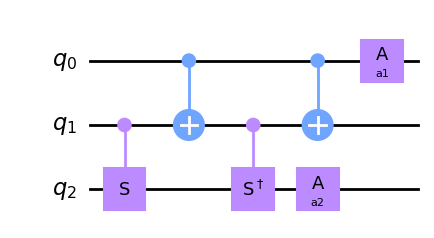

In [101]:
a1 = Parameter('a1')
a2 = Parameter('a2')

qc = QuantumCircuit(3)

qc.cs(1,2)
qc.cnot(0,1)
qc.csdg(1,2)
qc.cnot(0,1)
qc.append(AGate(a1), [0])
qc.append(AGate(a2), [2])


qc.draw('mpl')

In [102]:
a1_val = 1/np.sqrt(2)
print(f"a1 gate value {np.exp(1j*a1_val)}")

a2_val = 1/np.sqrt(2)
print(f"a2 gate value {np.exp(1j*a2_val)}")

a1 gate value (0.7602445970756302+0.6496369390800624j)
a2 gate value (0.7602445970756302+0.6496369390800624j)


In [103]:
def get_bounded_gate(qc, a1_val, a2_val):
    bound_qc = qc.bind_parameters({a1: a1_val, a2: a2_val})
    return Operator(bound_qc).data

In [104]:
# let a = 1/sqrt(2) (i + 1)
bound_qc = qc.bind_parameters({a1: a1_val, a2: a2_val})
mat = Operator(bound_qc).data
array_to_latex(mat)

<IPython.core.display.Latex object>

In [105]:
hs_dist = my_hilbert_schmidt_distance(mat, ccz_gate)
print("Hilbert-Schmidt Distance: ", hs_dist)

Hilbert-Schmidt Distance:  0.3860814327470109


In [76]:
avg_mat = (get_bounded_gate(qc, 1/np.sqrt(3), 1/np.sqrt(4)) + get_bounded_gate(qc, 1 /np.sqrt(4), 1/np.sqrt(3))) / 2

array_to_latex(avg_mat)

<IPython.core.display.Latex object>

In [77]:
avg_hs_dist = my_hilbert_schmidt_distance(avg_mat, ccz_gate)
print("Hilbert-Schmidt Distance: ", avg_hs_dist)

Hilbert-Schmidt Distance:  0.41556568058609233


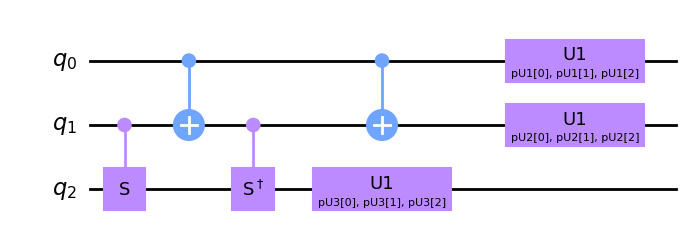

In [107]:
pU1 = ParameterVector('pU1', 3)
pU2 = ParameterVector('pU2', 3)
pU3 = ParameterVector('pU3', 3)

qc_ugates = QuantumCircuit(3)

qc_ugates.cs(1,2)
qc_ugates.cnot(0,1)
qc_ugates.csdg(1,2)
qc_ugates.cnot(0,1)
qc_ugates.append(SingleQubitU(*pU1), [0])
qc_ugates.append(SingleQubitU(*pU2), [1])
qc_ugates.append(SingleQubitU(*pU3), [2])


qc_ugates.draw('mpl')

In [108]:
def get_bounded_u_gates(qc, theta1, phi1, lam1, theta2, phi2, lam2, theta3, phi3, lam3):
    bound_qc = qc.bind_parameters({pU1[0]: theta1, pU1[1]: phi1, pU1[2]: lam1, pU2[0]: theta2, pU2[1]: phi2, pU2[2]: lam2, pU3[0]: theta3, pU3[1]: phi3, pU3[2]: lam3})
    return Operator(bound_qc).data

In [109]:
def get_avg_hs_ugates(params, qc, n):
    avg_mat = np.zeros((8,8), dtype=complex)
    for i in range(n):
        avg_mat += get_bounded_u_gates(qc, *params[i*9:(i+1)*9])
    avg_mat /= n
    return my_hilbert_schmidt_distance(avg_mat, ccz_gate)

In [110]:
n = 3
x0 = np.random.uniform(0, 2*np.pi, 9*n)
res = minimize(get_avg_hs_ugates, x0, args=(qc_ugates, n), method='Nelder-Mead', options={'disp': True, 'maxiter': 10000})
print(res)

Optimization terminated successfully.
         Current function value: 0.665731
         Iterations: 5910
         Function evaluations: 7272
 final_simplex: (array([[ 6.28319048e+00,  5.48749222e+00,  1.39785794e+00,
         1.16613237e-05,  5.42326009e+00,  6.69691428e-01,
         6.28319406e+00,  2.93028850e+00, -2.32814189e+00,
         6.28317674e+00,  1.75361693e+00,  6.20273529e-01,
         6.28322134e+00, -1.53220413e-01,  9.30979948e-01,
         6.28318325e+00,  2.17941557e+00,  6.47764484e+00,
        -8.07071137e-06,  4.90724410e+00,  1.97811103e+00,
        -1.17682830e-06,  4.12110089e+00,  1.97185105e+00,
         2.07629063e-06, -1.13543611e+00,  1.73756876e+00],
       [ 6.28319151e+00,  5.48750430e+00,  1.39785225e+00,
         2.07686935e-05,  5.42325080e+00,  6.69691243e-01,
         6.28319446e+00,  2.93028080e+00, -2.32813164e+00,
         6.28318203e+00,  1.75361543e+00,  6.20275023e-01,
         6.28319880e+00, -1.53216487e-01,  9.30974321e-01,
         6.283